In [31]:
import os 
import sys 
import numpy as np 
from ROOT import TCanvas, TGraph, TGraphAsymmErrors, TLegend, TLatex, TFile, TTree, TH2D, TGraph2D, TGraphSmooth, TIter
import ROOT as root
from array import array
from sys import argv,stdout,exit
from glob import glob
from collections import namedtuple


root.gStyle.SetOptStat(0)
root.gStyle.SetOptTitle(0)
root.gStyle.SetFrameLineWidth(2)
offshell=True
dosmooth = 'false'
root.gStyle.SetNumberContours(505);
root.gStyle.SetPalette(57)
XSECUNCERT=0.1
VERBOSE=False
drawLegend=True
iC=0
print ("import done")

import done


In [32]:
def get_contours(h2, cold):
    ctmp = TCanvas()
    ctmp.cd()
    h2.Draw("contlist")
    ctmp.Update()

    conts = root.gROOT.GetListOfSpecials().FindObject("contours")
    graphs = []
    for ib in range(conts.GetSize()):
        l = conts.At(ib)
        #graph = root.TGraph(l.First())                                                                                                                                                                         
        graph = l.First()
        if not graph:
            continue
        graph = root.TGraph(graph) # clone                                                                                                                                                                      
        graph.SetLineColor(h2.GetLineColor())
        graph.SetLineWidth(h2.GetLineWidth())
        graph.SetLineStyle(h2.GetLineStyle())
        graphs.append(graph)

    cold.cd()
    return graphs


In [33]:
L = namedtuple('L', ['mMed','mChi','down2','down1','cent','up1','up2','obs'])

def parseLimitFiles2D(filepath):
    limits = {}
    flist = list(open(filepath, 'r').readlines())
    for line in flist[1:]:
        l = L(*map(float, line.strip().split()))
        limits[(l.mMed , l.mChi )] = l
    print ('Successfully parsed %i points'%(len(limits)))
    return limits


In [34]:
def redrawBorder():
   root.gPad.Update()
   root.gPad.RedrawAxis()
   l = root.TLine()
   l.SetLineWidth(2)
   l.DrawLine(root.gPad.GetUxmin(), root.gPad.GetUymin(), root.gPad.GetUxmax(), root.gPad.GetUymin())
   l.DrawLine(root.gPad.GetUxmin(), root.gPad.GetUymin(), root.gPad.GetUxmin(), root.gPad.GetUymin())
   l.DrawLine(root.gPad.GetUxmin(), root.gPad.GetUymax(), root.gPad.GetUxmax(), root.gPad.GetUymax())
   l.DrawLine(root.gPad.GetUxmax(), root.gPad.GetUymax(), root.gPad.GetUxmax(), root.gPad.GetUymin())
   ## for background color inside the plot
   # root.gPad.GetFrame().SetFillColor(18)
   # root.gPad.GetFrame().SetBorderMode(-1)
   # root.gPad.GetFrame().SetBorderSize(5)

In [35]:
def SetLegend(coordinate_=[.50, .65, .90, .90], ncol=2):
    c_ = coordinate_
    legend = root.TLegend(c_[0], c_[1], c_[2], c_[3])
    legend.SetBorderSize(0)
    legend.SetNColumns(ncol)
    legend.SetLineColor(1)
    legend.SetLineStyle(1)
    legend.SetLineWidth(1)
    legend.SetFillColor(0)
    legend.SetFillStyle(0)
    legend.SetTextFont(42)
    legend.SetTextSize(0.045)
    return legend

Successfully parsed 81 points


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: grid (Potential memory leak).
Info in <TCanvas::Print>: png file limit_2hdma_ma_vs_tanbeta.png has been created
Info in <TCanvas::Print>: pdf file limit_2hdma_ma_vs_tanbeta.pdf has been created


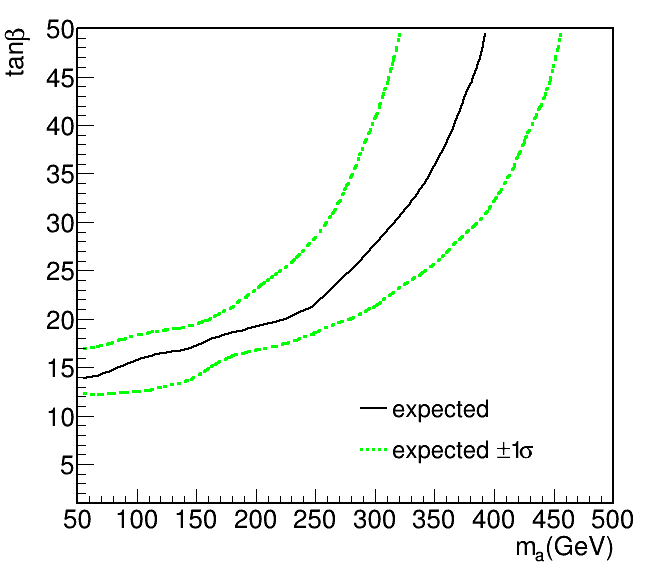

In [36]:
c = TCanvas("canvas", '',  650, 600)
c.SetTopMargin(0.05)
c.SetLeftMargin(0.12)
c.SetRightMargin(0.05)
c.SetBottomMargin(0.12)
c.SetFillColor(0)
legend = SetLegend([.55, .18, .78, .32], ncol=1)
#def makePlot2D(filepath,foutname,medcfg,chicfg,header='',offshell=False):
filepath="limits_tanb_vs_ma_scan.txt"

foutname="test_"
medcfg=[500,10,2600]
chicfg=[500,1,600]
limits = parseLimitFiles2D(filepath)
    
gs = {} ## create a dict of 2D graphs 
for g in ['exp','expup','expdown','obs','obsup','obsdown','expup2','expdown2']:
    gs[g] = TGraph2D()
iP=0
## create a 2D histogram with binined sent from function call
hgrid = TH2D('grid','grid',medcfg[0],medcfg[1],medcfg[2],chicfg[0],chicfg[1],chicfg[2])
for p in limits: 
    mMed = p[0]; mChi = p[1]
    l = limits[p]
    if l.obs==0 or l.cent==0:
        print ("problematic point: ",mMed,mChi)
        continue
    ## fill 2d histo 
    hgrid.Fill(mMed,mChi,l.cent)
    ## fill graphs 
    gs['exp'].SetPoint(iP,mMed,mChi,l.cent)
    gs['expup'].SetPoint(iP,mMed,mChi,l.up1)
    gs['expdown'].SetPoint(iP,mMed,mChi,l.down1)
    gs['obs'].SetPoint(iP,mMed,mChi,l.obs)
    gs['obsup'].SetPoint(iP,mMed,mChi,l.obs/(1-XSECUNCERT))
    gs['obsdown'].SetPoint(iP,mMed,mChi,l.obs/(1+XSECUNCERT))
    gs['expup2'].SetPoint(iP,mMed,mChi,l.up2)
    gs['expdown2'].SetPoint(iP,mMed,mChi,l.down2)
    iP += 1
    
    hs = {}
    for h in ['exp']:#,'expup','expdown','obs','obsup','obsdown','expup2','expdown2']:
        hs[h] = TH2D(h,h,medcfg[0],medcfg[1],medcfg[2],chicfg[0],chicfg[1],chicfg[2])
        # hs[h].SetStats(0); hs[h].SetTitle('')                                                                                                                                                                 
        for iX in range(0,medcfg[0]):
            for iY in range(0,chicfg[0]):
                x = medcfg[1] + (medcfg[2]-medcfg[1])*iX/medcfg[0]
                y = chicfg[1] + (chicfg[2]-chicfg[1])*iY/chicfg[0]
                #print (x,y)
                if not(offshell) and 2*y>x:
                    val = 9999
                else:
                    val = gs[h]#.Interpolate(x,y)
                if val == 0:
                    val = 9999

#hgrid.Draw("colz")
#gs['exp'].Draw("COLZ same")


h_exp = gs['exp'].GetHistogram()
h_exp.Smooth(1)
h_exp.SetMarkerColor(0)
h_exp.SetMarkerSize(0)
h_exp.Draw("")

h_exp.GetXaxis().SetLabelSize(0.049)
h_exp.GetYaxis().SetLabelSize(0.049)

h_exp.GetXaxis().SetTitle("m_{a}(GeV)")
h_exp.GetYaxis().SetTitle("tan#beta")

h_exp.GetXaxis().SetTitleSize(0.049)
h_exp.GetYaxis().SetTitleSize(0.049)
h_exp.GetXaxis().SetRangeUser(50,500)
h_exp.GetYaxis().SetRangeUser(1,50)


h_exp.GetYaxis().SetTitleOffset(1.2)

h_expup1 =  gs['expup'].GetHistogram()
h_expup1.Smooth(1)
h_expdown1 =  gs['expdown'].GetHistogram()
h_expdown1.Smooth(1)

h_expup2 =  gs['expup2'].GetHistogram()
h_expup2.Smooth(1)
h_expdown2 =  gs['expdown2'].GetHistogram()
h_expdown2.Smooth(1)


h_obs = gs['obs'].GetHistogram()
h_obs.Smooth(1)

gExp = TGraph2D(h_exp)
gExpup1 = TGraph2D(h_expup1)
gExpdown1 = TGraph2D(h_expdown1)
gExpup2 = TGraph2D(h_expup2)
gExpdown2 = TGraph2D(h_expdown2)
g_obs = TGraph2D(h_obs)


g=TGraph()
g_up_one = TGraph()
g_down1 = TGraph()
g_up2 = TGraph()
g_down2 = TGraph()
g_o =  TGraph()
if gExp.GetContourList(1.) != 0: 
    list_ = (gExp.GetContourList(1.))
    list_iter = TIter(list_)
    g = TGraph(list_[0])
    list_up1 = (gExpup1.GetContourList(1.))
    g_up1 = TGraph(list_up1[0])
    list_down1 = (gExpdown1.GetContourList(1.))
    g_down1 = TGraph(list_down1[0])
    list_up2 = (gExpup2.GetContourList(1.))
    g_up2 = TGraph(list_up2[0])
    list_down2 = (gExpdown2.GetContourList(1.))
    g_down2 = TGraph(list_down2[0])
    list_o = (g_obs.GetContourList(1.))
    g_o = TGraph(list_o[0])


g.SetLineWidth(2)
g.SetLineStyle(1)
# g.SetLineColor(root.kRed)
g.Draw("l")
legend.AddEntry(g, "expected", "l")


g_up1.SetLineWidth(3)
g_up1.SetLineStyle(2)
g_up1.SetLineColor(root.kGreen)
g_up1.Draw("same")
legend.AddEntry(g_up1, "expected #pm1#sigma", "l")

g_down1.SetLineWidth(3)
g_down1.SetLineStyle(2)
g_down1.SetLineColor(root.kGreen)
g_down1.Draw("same")

# g_up2.SetLineWidth(3)
# g_up2.SetLineStyle(2)
# g_up2.SetLineColor(root.kYellow)
# g_up2.Draw("same")
# legend.AddEntry(g_up2, "expected #pm2#sigma", "l")

# g_down2.SetLineWidth(3)
# g_down2.SetLineStyle(2)
# g_down2.SetLineColor(root.kYellow)
# g_down2.Draw("same")

g_o.SetLineWidth(2)
g_o.SetLineColor(root.kRed)
# g_o.Draw("same")
# legend.AddEntry(g_o, "Observed", "l")
legend.Draw('same')

redrawBorder()
c.Draw()
c.SaveAs("limit_2hdma_ma_vs_tanbeta.png")
c.SaveAs("limit_2hdma_ma_vs_tanbeta.pdf")
